In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
# from tqdm.auto import tqdm
# from scipy.signal import welch
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qick.asm_v2 import AveragerProgramV2

In [3]:
from qick.rfboard import RFQickSocV2
soc = RFQickSocV2('/home/xilinx/jupyter_notebooks/fw/2025-01-03_111_tprocv2r21_rfbv2/qick_111_rfbv2.bit')
soccfg = soc

print(soccfg)

resetting clocks: 122.88 204.8
QICK running on ZCU111, software version 0.2.301

Firmware configuration (built Fri Jan  3 15:35:30 2025):

	Global clocks (MHz): tProcessor 384.000, RF reference 204.800

	8 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 0 is DAC228_T0_CH0 or RF board output 0
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.667 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 1 is DAC228_T0_CH1 or RF board output 1
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.333 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 2 is DAC228_T0_CH2 or RF board output 2
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.333 us)
		fs=6144.000 MHz, fabric=384.000 MHz, 32-bit DDS, range=6144.000 MHz
		DAC tile 0, blk 3 is DAC228_T0_CH3 or RF boar

In [4]:
F_LO = 122.88*64
GEN_CH = 0
RO_CH = 0
RO_DC_CH = 2

In [5]:
soc.rfb_set_lo(F_LO, verbose=True)
# soc.rfb_set_lo(F_LO, ch=0, verbose=True) # ADCs
# soc.rfb_set_lo(F_LO, ch=1, verbose=True) # DACs 0-3
# soc.rfb_set_lo(F_LO, ch=2, verbose=True) # DACs 4-7

# as long as you're not saturating at any point in the chain (check with gain sweep), better to attenuate later
print("set attenuators:", soc.rfb_set_gen_rf(gen_ch=GEN_CH, att1=30, att2=31.75))
print("set attenuators:", soc.rfb_set_ro_rf(ro_ch=RO_CH, att=30))

  i |   f_vco  | DIV | MIN_N | DLY_SEL |   n  |   R  | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|-------|---------|------|------|-------|---------|----------|---------|------------
  0 |  7864.32 |   1 |    28 |       1 |   64 |    1 |     1 |  122.88 |  7864.32 |    0.00 | 6.4000e+01

Choosing solution 0 with minimal metric 64.
LO locked on attempt 1 after 0.01 sec
  i |   f_vco  | DIV | MIN_N | DLY_SEL |   n  |   R  | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|-------|---------|------|------|-------|---------|----------|---------|------------
  0 |  7864.32 |   1 |    28 |       1 |   64 |    1 |     1 |  122.88 |  7864.32 |    0.00 | 6.4000e+01

Choosing solution 0 with minimal metric 64.
LO locked on attempt 1 after 0.01 sec
  i |   f_vco  | DIV | MIN_N | DLY_SEL |   n  |   R  | R_pre |  f_pfd  |   f_out  | Delta f |   Metric   
----|----------|-----|-------|---------|------|------|-------|---------|----------|---------|-

  0%|          | 0/1 [00:00<?, ?it/s]

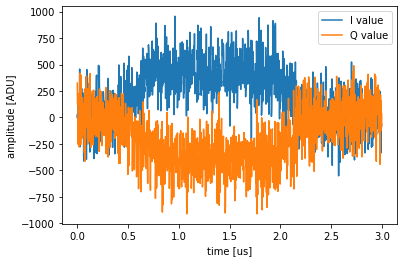

In [6]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'])
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_cosine(ch=gen_ch, name="ramp", length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
#                        style="const",
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
    def _body(self, cfg):
        self.delay_auto()
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': 1000,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'flat_len': 1.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 1.0
         }
prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 30, 30)
# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'], 30)
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

set gain: 10


  0%|          | 0/1 [00:00<?, ?it/s]

read gain: 10


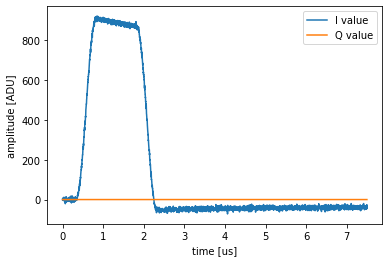

In [7]:
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_DC_CH,
          'freq': 0,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 7.5,
          'flat_len': 1.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 0.1
         }
prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
soc.rfb_set_gen_dc(config['gen_ch'])
print("set gain:", soc.rfb_set_ro_dc(config['ro_ch'], 10))
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");
print("read gain:", soc.adc_chains[4].get_gain())

In [8]:
print("read bias:", soc.rfb_get_bias(0))
print("set bias:", soc.rfb_set_bias(0, 1))
print("read bias:", soc.rfb_get_bias(0))

read bias: 3.8147118175402284e-05
set bias: 1.0000267029827228
read bias: 1.0000267029827228
